In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import pickle

In [2]:
nlp=spacy.load('en_core_web_lg')

In [3]:
df = pd.read_csv('combined_csv.csv')
df.head(10)

,data,category
0,Sport pertains to any form of competitive phys...,sports
1,"Sports can, through casual or organized parti...",sports
2,"Hundreds of sports exist, from those between ...",sports
3,"In certain sports such as racing, many contes...",sports
4,"Some sports allow a ""tie"" or ""draw"", in which...",sports
5,A number of contests may be arranged in a tou...,sports
6,Many sports leagues make an annual champion b...,sports
7,Sport is generally recognised as system of act...,sports
8,"Other organisations, such as the Council of E...",sports
9,"However, a number of competitive, but non-phy...",sports


In [4]:
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
df.head(10)

,data,category
580,The earliest evidence that games resembling fo...,sports
5191,"In July 2010, the US Treasury Department adde...",terrorism
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism
2576,"When the representative is one man, then is t...",politics
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism
3835,"Revolutionary taxes ""play a secondary role as...",terrorism
21,"Roget's defines the noun sport as an ""activit...",sports
1846,"Scholars such as Steven Weber, David Woodward...",politics
4330,"""Goetz writes that most homicides seem to star...",terrorism
4652,legitimated jihad against anyone who refused ...,terrorism


[1, 2, 3] ['politics' 'terrorism' 'sports'] terrorism    1837
politics     1806
sports       1773
Name: category, dtype: int64


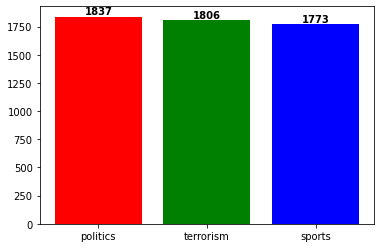

In [6]:
topics = df['category'].unique()
topics=topics[::-1]
left = [1,2,3]
vals = df['category'].value_counts()

print(left,topics,vals)
graph = plt.bar(left,vals,tick_label=topics,width=0.8,color=['red','green','blue'])
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(vals[i]),
             ha='center',
             weight='bold')
    i+=1

In [7]:
type(topics)

numpy.ndarray

In [8]:
def clean_text(text): 
    text = text.lower() 
    text = " ".join(filter(lambda x:x[0]!='@', text.split())) 
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
new_text=[]
for text in df['data']:  
      new_text.append(clean_text(text))
df['clean_text']=new_text

In [10]:
df

,data,category,clean_text
580,The earliest evidence that games resembling fo...,sports,the earliest evidence that games resembling fo...
5191,"In July 2010, the US Treasury Department adde...",terrorism,in july 2010 the us treasury department added ...
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between 1918 and 1919 in the shia holy city of...
2576,"When the representative is one man, then is t...",politics,when the representative is one man then is the...
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism,however after the war on terror alqaedas leade...
...,...,...,...
2521,King of Liberia was reported to have won by 2...,politics,king of liberia was reported to have won by 23...
4353,"Not surprisingly, scientific evidence about th...",terrorism,not surprisingly scientific evidence about the...
3373,"First of all, the absence of effective govern...",politics,first of all the absence of effective governan...
1119,"In a man-to-man defense, each defensive playe...",sports,in a mantoman defense each defensive player gu...


In [11]:
df['tidy_tweet']=df['clean_text'].str.replace("[^a-zA-Z#]"," ")

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [12]:
df['tidy_tweet']=df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [13]:
df.drop('clean_text',axis=1,inplace=True)

In [14]:
df.head(10)

,data,category,tidy_tweet
580,The earliest evidence that games resembling fo...,sports,earliest evidence that games resembling footba...
5191,"In July 2010, the US Treasury Department adde...",terrorism,july treasury department added list specially ...
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between shia holy city najaf league islamic aw...
2576,"When the representative is one man, then is t...",politics,when representative then commonwealth monarchy...
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism,however after terror alqaedas leadership becom...
3835,"Revolutionary taxes ""play a secondary role as...",terrorism,revolutionary taxes play secondary role other ...
21,"Roget's defines the noun sport as an ""activit...",sports,rogets defines noun sport activity engaged rel...
1846,"Scholars such as Steven Weber, David Woodward...",politics,scholars such steven weber david woodward mich...
4330,"""Goetz writes that most homicides seem to star...",terrorism,goetz writes that most homicides seem start fr...
4652,legitimated jihad against anyone who refused ...,terrorism,legitimated jihad against anyone refused abide...


In [15]:
df[1:3]

,data,category,tidy_tweet
5191,"In July 2010, the US Treasury Department adde...",terrorism,july treasury department added list specially ...
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between shia holy city najaf league islamic aw...


In [16]:
df['tidy_tweet'][137]

'plays farces spectacles gladiators strange beasts medals pictures other such opiates these were ancient peoples bait toward slavery price their liberty instruments tyranny'

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5416 entries, 580 to 2118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        5416 non-null   object
 1   category    5416 non-null   object
 2   tidy_tweet  5416 non-null   object
dtypes: object(3)
memory usage: 298.3+ KB


In [18]:
df.isnull().sum()

data          0
category      0
tidy_tweet    0
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
blancks = []
for i,qn,y,b in df.itertuples():
    if type(b) == str:
        if b.isspace() or b=='':
            blancks.append(i)
blancks

[]

In [21]:
df.drop(blancks,inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5416 entries, 580 to 2118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        5416 non-null   object
 1   category    5416 non-null   object
 2   tidy_tweet  5416 non-null   object
dtypes: object(3)
memory usage: 298.3+ KB


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')

In [24]:
dtm = tfidf.fit_transform(df['tidy_tweet'])

In [25]:
dtm

<5416x6094 sparse matrix of type '<class 'numpy.float64'>'
	with 54760 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.decomposition import NMF

In [27]:
nmf_model = NMF(n_components=3,random_state=42)

In [28]:
nmf_model.fit(dtm)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


NMF(n_components=3, random_state=42)

In [29]:
for i, arr in enumerate(nmf_model.components_):
    print(f"The words of NMF of high frequency of {i} is")
    print([tfidf.get_feature_names()[i] for i in arr.argsort()[-25:]])
    print('\n')

The words of NMF of high frequency of 0 is
['american', 'international', 'england', 'popular', 'league', 'australian', 'teams', 'sports', 'play', 'cricket', 'century', 'sport', 'known', 'basketball', 'association', 'team', 'hockey', 'rugby', 'players', 'rules', 'games', 'ball', 'played', 'game', 'football']


The words of NMF of high frequency of 1 is
['cabinet', 'term', 'house', 'union', 'office', 'power', 'constitution', 'parliamentary', 'ministers', 'executive', 'republics', 'india', 'title', 'elected', 'council', 'parliament', 'state', 'republic', 'united', 'head', 'minister', 'prime', 'government', 'states', 'president']


The words of NMF of high frequency of 2 is
['forms', 'military', 'term', 'group', 'attacks', 'according', 'terrorist', 'politics', 'international', 'policy', 'people', 'used', 'islamic', 'health', 'groups', 'social', 'public', 'world', 'state', 'governance', 'alqaeda', 'terrorism', 'jihad', 'political', 'violence']




In [30]:
topic_sel = nmf_model.transform(dtm)

In [31]:
topic_sel


array([[0.07794543, 0.        , 0.00836022],
       [0.        , 0.        , 0.03932841],
       [0.00745466, 0.00264984, 0.02616706],
       ...,
       [0.        , 0.01102842, 0.0783093 ],
       [0.01017232, 0.        , 0.00661249],
       [0.01745516, 0.0164335 , 0.01585219]])

In [32]:
g_df = []
for j in range(0,3):
    op= []
    for i,data,cat,tt in df.itertuples():
        if(topic_sel[i].argmax()==j):
            op.append(topic_sel[i].max())
    g_df.append(op)
# g_df[0]
# g_df

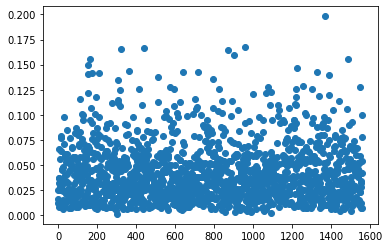

In [33]:
x =range(0,len(g_df[0]))
y = g_df[0]
plt.scatter(x,y)
plt.show()

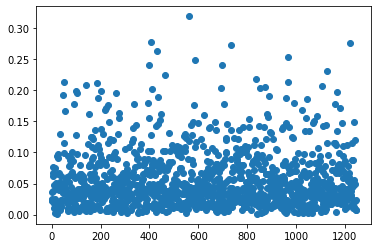

In [34]:
x =range(0,len(g_df[1]))
y = g_df[1]
plt.scatter(x,y)
plt.show()

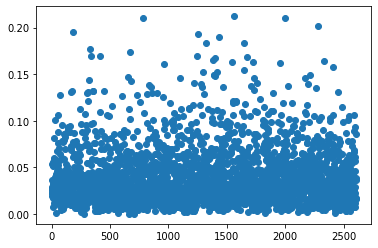

In [35]:
x =range(0,len(g_df[2]))
y = g_df[2]
plt.scatter(x,y)
plt.show()

In [36]:
df[3938:3942]

,data,category,tidy_tweet
3756,The majority of incidents over the past sever...,terrorism,majority incidents over past several years tie...
1100,(Some scoreboards also indicate the number of...,sports,some scoreboards also indicate number fouls co...
294,"There is no standard for the weight, which is...",sports,there standard weight which usually between
2610,"President"" and Madam President may apply to a...",politics,president madam president apply person holding...


In [37]:
vals={0:'sports',1:'politics',2:'terrorism'}

In [38]:
df['topic']=topic_sel.argmax(axis=1)

In [39]:
df.head()

,data,category,tidy_tweet,topic
580,The earliest evidence that games resembling fo...,sports,earliest evidence that games resembling footba...,0
5191,"In July 2010, the US Treasury Department adde...",terrorism,july treasury department added list specially ...,2
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between shia holy city najaf league islamic aw...,2
2576,"When the representative is one man, then is t...",politics,when representative then commonwealth monarchy...,1
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism,however after terror alqaedas leadership becom...,2


In [40]:
df['category_decided']=df['topic'].map(vals)

In [41]:
df.shape

(5416, 5)

In [42]:
df.shape

(5416, 5)

In [43]:
df

,data,category,tidy_tweet,topic,category_decided
580,The earliest evidence that games resembling fo...,sports,earliest evidence that games resembling footba...,0,sports
5191,"In July 2010, the US Treasury Department adde...",terrorism,july treasury department added list specially ...,2,terrorism
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between shia holy city najaf league islamic aw...,2,terrorism
2576,"When the representative is one man, then is t...",politics,when representative then commonwealth monarchy...,1,politics
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism,however after terror alqaedas leadership becom...,2,terrorism
...,...,...,...,...,...
2521,King of Liberia was reported to have won by 2...,politics,king liberia reported have votes general elect...,1,politics
4353,"Not surprisingly, scientific evidence about th...",terrorism,surprisingly scientific evidence about effecti...,2,terrorism
3373,"First of all, the absence of effective govern...",politics,first absence effective governance lack capaci...,2,terrorism
1119,"In a man-to-man defense, each defensive playe...",sports,mantoman defense each defensive player guards ...,0,sports


In [44]:
df.drop('topic',axis=1,inplace=True)

In [45]:
df


,data,category,tidy_tweet,category_decided
580,The earliest evidence that games resembling fo...,sports,earliest evidence that games resembling footba...,sports
5191,"In July 2010, the US Treasury Department adde...",terrorism,july treasury department added list specially ...,terrorism
4712,Between 1918 and 1919 in the Shia holy city o...,terrorism,between shia holy city najaf league islamic aw...,terrorism
2576,"When the representative is one man, then is t...",politics,when representative then commonwealth monarchy...,politics
4869,"However, after the War on Terror, al-Qaeda's ...",terrorism,however after terror alqaedas leadership becom...,terrorism
...,...,...,...,...
2521,King of Liberia was reported to have won by 2...,politics,king liberia reported have votes general elect...,politics
4353,"Not surprisingly, scientific evidence about th...",terrorism,surprisingly scientific evidence about effecti...,terrorism
3373,"First of all, the absence of effective govern...",politics,first absence effective governance lack capaci...,terrorism
1119,"In a man-to-man defense, each defensive playe...",sports,mantoman defense each defensive player guards ...,sports


In [47]:
print(accuracy_score(df['category'],df['category_decided']))

0.7795420974889217


In [48]:
print(classification_report(df['category'],df['category_decided']))

              precision    recall  f1-score   support

    politics       0.83      0.58      0.68      1806
      sports       0.96      0.84      0.90      1773
   terrorism       0.65      0.92      0.76      1837

    accuracy                           0.78      5416
   macro avg       0.81      0.78      0.78      5416
weighted avg       0.81      0.78      0.78      5416



In [49]:
print(confusion_matrix(df['category'],df['category_decided']))

[[1040   46  720]
 [  83 1492  198]
 [ 124   23 1690]]


In [50]:
x_train,x_test,y_train,y_test = train_test_split(df['data'],df['category_decided'],test_size=0.33,random_state=42)

In [51]:
tf_vect = TfidfVectorizer()

In [52]:
lin_svc = LinearSVC()

In [53]:
rt = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('lin_svc',LinearSVC())])

In [54]:
rt.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('lin_svc', LinearSVC())])

In [55]:
op = rt.predict(x_test)

In [56]:
print(accuracy_score(op,y_test))

0.9155480984340044


In [57]:
print(classification_report(op,y_test))

              precision    recall  f1-score   support

    politics       0.84      0.92      0.88       371
      sports       0.92      0.92      0.92       499
   terrorism       0.95      0.91      0.93       918

    accuracy                           0.92      1788
   macro avg       0.90      0.92      0.91      1788
weighted avg       0.92      0.92      0.92      1788



In [58]:
print(confusion_matrix(op,y_test))

[[343   6  22]
 [ 14 460  25]
 [ 51  33 834]]


In [59]:
with open("model_pickle","wb") as f:
    pickle.dump(rt,f)

In [60]:
rt.predict(["hi i love to play football."])

array(['sports'], dtype=object)